In [32]:
"""
Plot to show fitness over generations
"""

import matplotlib.pyplot as plt

def plot(results, param, fitness_type=fitness, jitter=0):
    
    plt.figure(figsize=(12, 10))
    plt.title(f"Comparing {param}")
    plt.xlabel("Generation")
    plt.ylabel(f"{fitness_type}")
    
    param_values = []
    color_map = {}
    color_legend = {}

    for result in results:

        if result[param] not in param_values:
            param_values.append(result[param])
        
        best_fitness = result[fitness_type]
        generations = range(len(best_fitness))
        
        if jitter:
            jitter_amount = random.uniform(-jitter, jitter)
            best_fitness_j = [f + jitter_amount for f in best_fitness]
        else:
            best_fitness_j = best_fitness

        if result[param] == param_values[0]:
            colour = "blue"
        else:
            colour = "green"
            
        if colour not in color_legend:
            color_legend[colour] = f"{param} = {result[param]}"

        plt.plot(generations, best_fitness_j, color=colour)

    legend_handles = [plt.Line2D([0], [0], color=color, label=label) for color, label in color_legend.items()]
    plt.legend(handles=legend_handles, loc="best")
        
    plt.grid(True)
    plt.show()
    

In [33]:
"""
Plot to show how strategy of any memory length makes a choice
"""

import networkx as nx

def binary_tree_plot(strategy):
    
    leaves = strategy[1:]
    num_leaf_nodes = len(leaves)
    tree_depth = int(math.log2(num_leaf_nodes))
    
    edge_labels = {}
    node_labels = {}
    node_colours = {}

    G = nx.DiGraph()

    node_count = 1
    G.add_node(node_count)
    node_labels[node_count] = ""
    node_colours[node_count] = "lightblue"
    node_count += 1
    
    for branch in range(1, tree_depth):
        
        for i in range(2**branch):
            
            G.add_node(node_count)
            
            if (node_count % 2): # if odd
                node_labels[node_count] = ""
            else:
                node_labels[node_count] = ""
            node_colours[node_count] = "lightblue"
            node_count += 1
            
    for leaf in leaves:
        
        G.add_node(node_count)
        
        if leaf: # if one
            node_labels[node_count] = "C"
            node_colours[node_count] = "lightgreen"
        else:
            node_labels[node_count] = "D"
            node_colours[node_count] = "pink"
        node_count += 1
            
    for node in range(1, 2**tree_depth):
        if node < 2**(tree_depth-1):
            G.add_edge(node, 2*node)
            edge_labels[(node, 2*node)] = "D"
            G.add_edge(node, 2*node + 1)
            edge_labels[(node, 2*node + 1)] = "C"
        else:
            G.add_edge(node, 2*node)
            G.add_edge(node, 2*node + 1)
            edge_labels[(node, 2*node)] = ""
            edge_labels[(node, 2*node + 1)] = ""

    pos = {}
    x, y = 12, 8
    pos[1] = (x, y)
    
    width = 2*x
    for level in range(1, tree_depth + 1):
        y-= 2
        for i in range(2**level):
            node = (2**level) + i
            increment = width/(2**level+1)
            x = (i+1) * increment
            pos[node] = (x, y)
    
    #print((width-increment), y)
    pos[2**(tree_depth+2)] = ((width-increment), y)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=node_labels, node_color=[node_colours[node] for node in G.nodes()], with_labels=True, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Strategy Tree Choice Visualization")
    plt.show()

In [34]:
"""
UNCHANGED GENETIC ALGORITHM COMPONENTS
"""

always_cooperates = [1, 1, 1]                  
always_defects = [0, 0, 0]
tit_for_tat = [1, 0, 1]
fixed_strategies = [always_cooperates, always_defects, tit_for_tat]


import random

random.seed(214)

def random_pop(n, memory_length): # makes random prisoner strategies of specified memory length (with duplicate individuals)
    
    pop = []
    indices = list(range(1 + 2**memory_length))
    
    for individual in range(n):
        num_cooperations = random.randint(0, (1 + 2**memory_length))
        cooperation_indices = random.sample(indices, num_cooperations)
        pop.append([1 if index in cooperation_indices else 0 for index in indices])

    return pop


def strat(prisoner, seqSelf, seqOpp, memory_length): # return 1 for cooperate OR 0 for defect
    
    game_length = len(seqSelf)
    
    if game_length < memory_length: 
        
        if game_length == 0: # what to do on the first move
            return prisoner[0] # predefined first move

        else: # what to do before game is the length of the memory of the agents
            choice_remainders = list(range(2**(memory_length - game_length)))

            count = 0
            base = 1
            for i in range(game_length):
                base += (seqOpp[i] * (2**(memory_length - game_length)))
                count += 1

            choices = [base + remainder for remainder in choice_remainders]
            total_cooperations = sum(prisoner[choice] for choice in choices)

            if total_cooperations < 2**(memory_length - game_length - 1):
                return 0
            else:
                return 1

    else:
        count = 0
        move_index = 1
        while count < memory_length:
            move_index += (seqOpp[-memory_length + count] * (2**(memory_length - count - 1)))
            count += 1
        return prisoner[move_index]

    
import math

payoff_matrix = [[(3, 3), (0, 5)],
                 [(5, 0), (1, 1)]]

def iterated_dilemma(prisonerA, prisonerB, n):
    
    memoryA, memoryB = int(math.log2(len(prisonerA) - 1)), int(math.log2(len(prisonerB) - 1)) # memory length of each prisoner
    seqA, seqB = [], [] # sequence of moves for each prisoner
    payoffA, payoffB = 0, 0 # payoff for each prisoner

    for i in range(n): # number of iteration of the dilemma
        
        # move for each prisoner
        moveA = strat(prisonerA, seqA, seqB, memoryA)
        moveB = strat(prisonerB, seqB, seqA, memoryB)
        
        # adds the move to the sequence of previous moves for each prisoner
        seqA.append(moveA)
        seqB.append(moveB)
        
        # calculates once-off pay-off for each prisoner based on move
        if moveA and moveB:
            scoreA, scoreB =  payoff_matrix[0][0]
        elif moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[0][1]
        elif not moveA and moveB:
            scoreA, scoreB =  payoff_matrix[1][0]
        elif not moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[1][1]
        
        # adds once-off pay-off to total pay-off for each prisoner
        payoffA += scoreA
        payoffB += scoreB
        
    return payoffA, payoffB


def ordered_crossover(parent1, parent2):
    
    n = len(parent1)
    subset_length = (n-1)//4
    
    start_index = random.randint(1, n-subset_length)
    end_index = start_index + subset_length
    
    subset1a, subset1b, subset1c = parent1[:start_index], parent1[start_index:end_index], parent1[end_index:]
    subset2a, subset2b, subset2c = parent2[:start_index], parent2[start_index:end_index], parent2[end_index:]
    
    child1, child2 = [], []
    
    child1.extend(subset1a)
    child1.extend(subset2b) 
    child1.extend(subset1c)

    child2.extend(subset2a)
    child2.extend(subset1b)
    child2.extend(subset2c)
                
    return child1, child2


def split_crossover(parent1, parent2):
    
    n = len(parent1)
    split_index = (n+1)//2
    
    subset1a, subset1b = parent1[:split_index], parent1[split_index:]
    subset2a, subset2b = parent2[:split_index], parent2[split_index:]
    
    child1, child2 = [], []
    
    child1.extend(subset1a)
    child1.extend(subset2b) 

    child2.extend(subset2a)
    child2.extend(subset1b)
                
    return child1, child2


def reverse_sequence_mutation(prisoner):
    
    n = len(prisoner)
    
    start_index = random.randint(0, n-2)
    end_index = random.randint(start_index, n-1)

    subset = prisoner[start_index:end_index]
    reverse_subset = subset[::-1]
    
    mutation = prisoner[:start_index] + reverse_subset + prisoner[end_index:]

    return mutation


def inverse_mutation(prisoner):
    
    n = len(prisoner)
    
    start_index = random.randint(0, n-2)
    end_index = random.randint(start_index, n-1)

    subset = prisoner[start_index:end_index]
    inverse_subset = [(choice + 1) % 2 for choice in subset]

    mutation = prisoner[:start_index] + inverse_subset + prisoner[end_index:]

    return mutation


In [35]:
"""
CHANGED GENETIC ALGORITHM COMPONENTS

• Co-evolutionary approach
"""


def fitness(prisoner, n, pop):
    
    opponents = random.sample(pop, len(pop)//10)
    
    sum_payoff = 0
    
    for opponent in opponents:
        payoff, opp_payoff = iterated_dilemma(prisoner, opponent, n)
        sum_payoff += payoff
                
    average_payoff = sum_payoff/len(opponents) # average payoff against fixed strategies
    expected_payoff = average_payoff/n # expected payoff for prisoner for any iteration
    return expected_payoff 

def tournament_selection(pop, n=20, k=2, tournament_size=4):
    
    selection = []
    
    for individual in range(k):
        candidates = random.sample(pop, tournament_size)
        best = max(candidates, key=lambda candidate: fitness(candidate, n, pop))
        selection.append(best)
        
    return tuple(selection)

def run_genetic_algorithm(population_size, num_iterations, memory_length, num_generations, crossover_operator,
                          mutation_operator, mutation_rate):
    
    # features to track
    gen_count = 0
    gen_counts = []
    gen_best_fitnesses = []
    gen_best_strategies = []
    gen_mean_fitnesses = []
    gen_min_fitnesses = []
    gen_times = []
    
    pop = random_pop(population_size, memory_length) # initialises population
        
    no_improvement_count = 0 # counter to stop the code if we get 5 generations without improvement
    prev_best_fitness = float('inf')
    prev_mean_fitness = float('inf')

    for generation in range(num_generations):
        
        start_time = time.time() # starts timer
        
        fitnesses = [fitness(prisoner, num_iterations, pop) for prisoner in pop] # calculates individuals fitnesses
        new_pop = []

        while len(new_pop) < population_size: # assigns new individuals to the population for next generation
            
            parent1, parent2 = tournament_selection(pop, num_iterations, 2, 4) # tournament selection for choosing parents
            
            # applying crossover operator to create children
            if crossover_operator == 'ordered':
                child1, child2 = ordered_crossover(parent1, parent2)
            elif crossover_operator == 'split':
                child1, child2 = split_crossover(parent1, parent2)
                
            # random chance of mutation
            if random.random() < mutation_rate:
                if mutation_operator == 'reverse_sequence':
                    child1 = reverse_sequence_mutation(child1)
                elif mutation_operator == 'inverse':
                    child1 = inverse_mutation(child1)
                    
            # independent random chance of the second child mutating        
            if random.random() < mutation_rate:
                if mutation_operator == 'reverse_sequence':
                    child2 = reverse_sequence_mutation(child2)
                elif mutation_operator == 'inverse':
                    child2 = inverse_mutation(child2)

            new_pop.append(child1)
            new_pop.append(child2)
                        
        pop = new_pop # assigns the new generation to be the current generation
            
        # calculating results for the current generation
        gen_count = gen_count + 1
        gen_best_fitness = max(fitnesses)
        gen_best_strategy = pop[fitnesses.index(gen_best_fitness)]
        gen_mean_fitness = sum(fitnesses) / population_size
        gen_min_fitness = min(fitnesses)
        gen_time = time.time() - start_time # ends timer
        
        # adds results
        gen_counts.append(gen_count)
        gen_best_fitnesses.append(gen_best_fitness)
        gen_best_strategies.append(gen_best_strategy)
        gen_mean_fitnesses.append(gen_mean_fitness)
        gen_min_fitnesses.append(gen_min_fitness)
        gen_times.append(gen_time)
        
        #""" 
        # if theres no improvement of the best generation fitness
        if gen_best_fitness <= prev_best_fitness:
            no_improvement_count = no_improvement_count + 1
        else:
            no_improvement_count = 0
        
        # stops the evolution algorithm if no improvement in 5 generations
        if no_improvement_count >= 10:
            break
        #"""

        prev_best_fitness = gen_best_fitness
    
    # dictionary for results
    implementation_data = {
        "gen_counts": gen_counts,
        "gen_best_strategies": gen_best_strategies,
        "gen_best_fitnesses": gen_best_fitnesses,
        "gen_mean_fitnesses": gen_mean_fitnesses,
        "gen_min_fitnesses": gen_min_fitnesses,
        "gen_compute_time": gen_times
    }
        
    return implementation_data, pop


In [36]:
"""
• Extend your representation (genotype) and compare the findings
"""

# DEFINING HYPERPARAMETERS TO BE USED

population_sizes = [100]
memory_lengths = [5] # doubles search space
crossover_operators = ['ordered', 'split']
mutation_operators = ['reverse_sequence', 'inverse']
mutation_rates = [0.1, 0.25]

# GRID SEARCH ALL HYPERPARAMETER COMBINATIONS

results2 = []

for crossover_operator in crossover_operators:
    for mutation_operator in mutation_operators:
        for mutation_rate in mutation_rates:

            print("Crossover Operator =", crossover_operator, "\nMutation Operator =", mutation_operator, "\nMutation Rate =", mutation_rate)

            start_time = time.time()
            result, final_pop = run_genetic_algorithm(population_sizes[0], 40, memory_lengths[0], 40, crossover_operator, mutation_operator, mutation_rate)
            best_strategy = result['gen_best_strategies'][-1]
            print("Best Strategy =", best_strategy, "\nFitness =", fitness(best_strategy, 40, final_pop), "\nTime Taken = ", round(time.time()-start_time), "seconds\n")

            results2.append({
                'strategy': best_strategy,
                'best fitness per generation': result['gen_best_fitnesses'],
                'mean fitness per generation': result['gen_mean_fitnesses'],
                'population_size': population_size,
                'memory_length': memory_length,
                'crossover': crossover_operator,
                'mutation': mutation_operator,
                'mutation rate': mutation_rate
            })
            

Crossover Operator = ordered 
Mutation Operator = reverse_sequence 
Mutation Rate = 0.1
Best Strategy = [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 
Fitness = 2.0575 
Time Taken =  51 seconds

Crossover Operator = ordered 
Mutation Operator = reverse_sequence 
Mutation Rate = 0.25
Best Strategy = [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0] 
Fitness = 1.78 
Time Taken =  53 seconds

Crossover Operator = ordered 
Mutation Operator = inverse 
Mutation Rate = 0.1
Best Strategy = [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0] 
Fitness = 2.18 
Time Taken =  55 seconds

Crossover Operator = ordered 
Mutation Operator = inverse 
Mutation Rate = 0.25
Best Strategy = [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0] 
Fitness = 1.955 
Time Taken =  52 seconds

Crossover Operator = spli

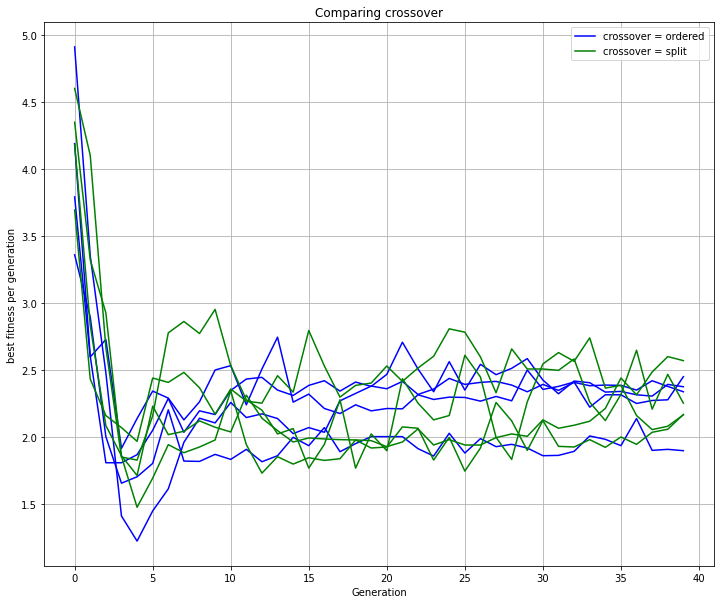

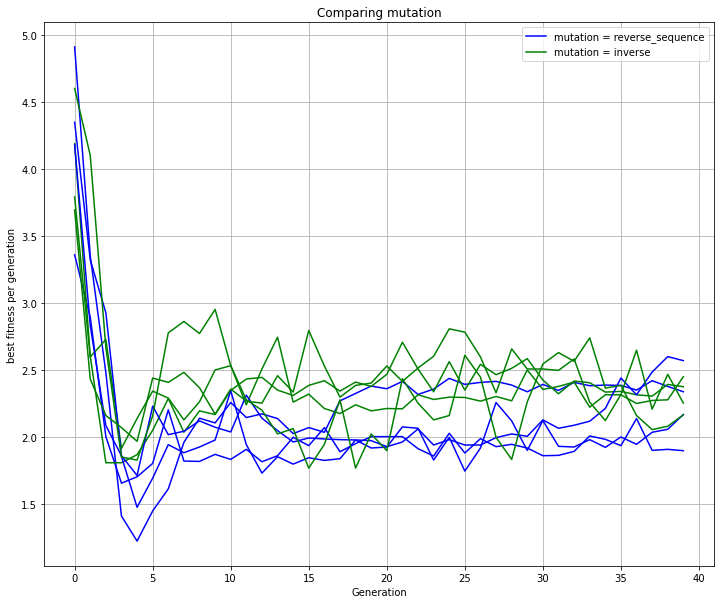

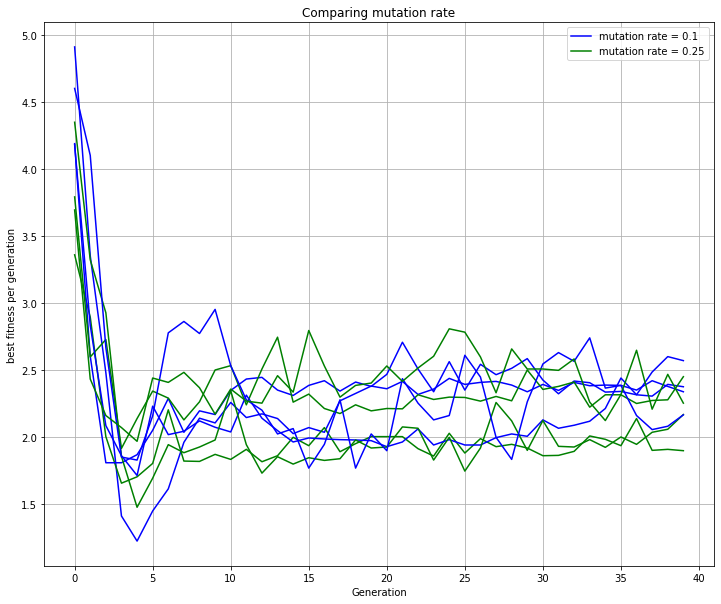

In [37]:
# Plotting best population fitness over generations

plot(results2, 'crossover', 'best fitness per generation')
plot(results2, 'mutation', 'best fitness per generation')
plot(results2, 'mutation rate', 'best fitness per generation')

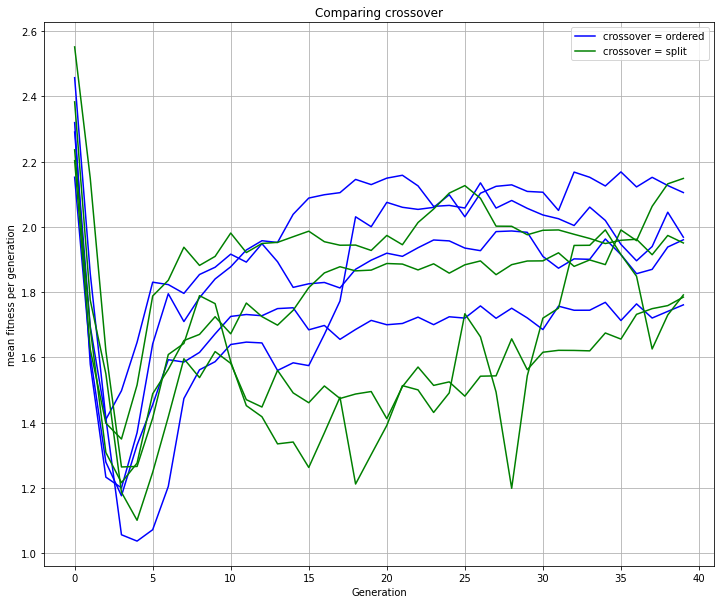

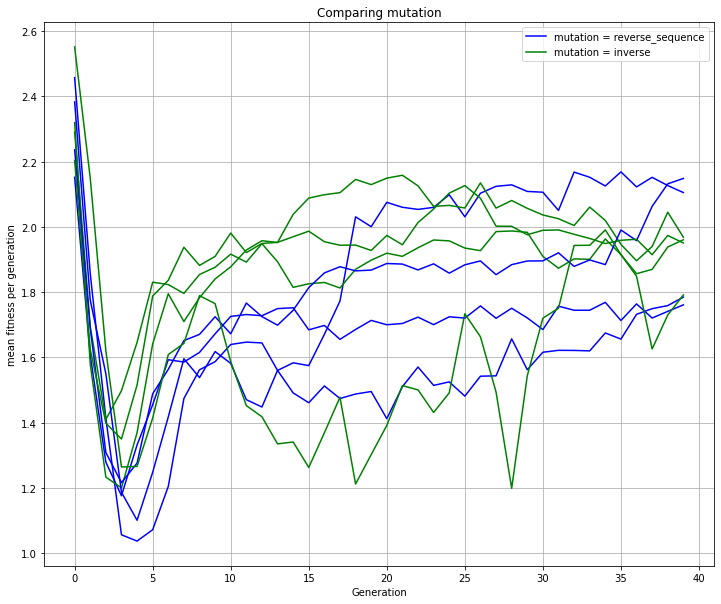

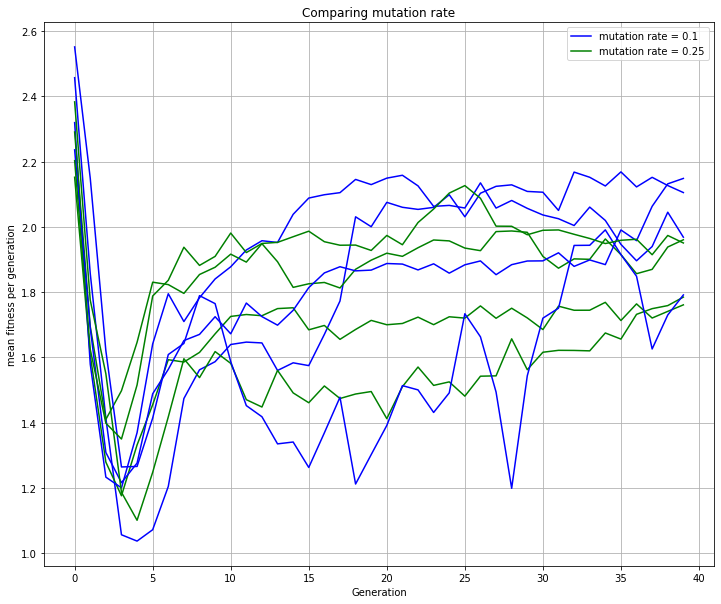

In [38]:
# Plotting mean population fitness over generations

plot(results2, 'crossover', 'mean fitness per generation')
plot(results2, 'mutation', 'mean fitness per generation')
plot(results2, 'mutation rate', 'mean fitness per generation')

In [39]:
for best_result in results1:
    best_strategy = best_result['strategy']
    print(best_strategy)
    binary_tree_plot(best_strategy)

In [40]:
"""
ADDING NOISE TO DECISIONS
"""

def flip(bit):
    return (bit + 1) % 2


In [46]:
"""
CHANGED GENETIC ALGORITHM COMPONENTS

• Consider the introduction of noise
"""

def strat(prisoner, seqSelf, seqOpp, memory_length, noise_rate): # return 1 for cooperate OR 0 for defect
    
    game_length = len(seqSelf)
    
    if game_length < memory_length: 
        
        if game_length == 0: # what to do on the first move
            choice = prisoner[0] # predefined first move

        else: # what to do before game is the length of the memory of the agents
            choice_remainders = list(range(2**(memory_length - game_length)))

            count = 0
            base = 1
            for i in range(game_length):
                base += (seqOpp[i] * (2**(memory_length - game_length)))
                count += 1

            choices = [base + remainder for remainder in choice_remainders]
            total_cooperations = sum(prisoner[choice] for choice in choices)

            if total_cooperations < 2**(memory_length - game_length - 1):
                choice = 0
            else:
                choice = 1

    else:
        count = 0
        move_index = 1
        while count < memory_length:
            move_index += (seqOpp[-memory_length + count] * (2**(memory_length - count - 1)))
            count += 1
        choice = prisoner[move_index]
        
    if random.random() < noise_rate:
        return flip(choice)
    else:
        return choice
    
    
def fitness(prisoner, n, pop, noise_rate):
    
    opponents = random.sample(pop, len(pop)//10)
    
    sum_payoff = 0
    
    for opponent in opponents:
        payoff, opp_payoff = iterated_dilemma(prisoner, opponent, n, noise_rate)
        sum_payoff += payoff
                
    average_payoff = sum_payoff/len(opponents) # average payoff against fixed strategies
    expected_payoff = average_payoff/n # expected payoff for prisoner for any iteration
    return expected_payoff 


def tournament_selection(pop, n=20, k=2, tournament_size=4, noise_rate=0.1):
    
    selection = []
    
    for individual in range(k):
        candidates = random.sample(pop, tournament_size)
        best = max(candidates, key=lambda candidate: fitness(candidate, n, pop, noise_rate))
        selection.append(best)
        
    return tuple(selection)
    
    
def iterated_dilemma(prisonerA, prisonerB, n, noise_rate):
    
    memoryA, memoryB = int(math.log2(len(prisonerA) - 1)), int(math.log2(len(prisonerB) - 1)) # memory length of each prisoner
    seqA, seqB = [], [] # sequence of moves for each prisoner
    payoffA, payoffB = 0, 0 # payoff for each prisoner

    for i in range(n): # number of iteration of the dilemma
        
        # move for each prisoner
        moveA = strat(prisonerA, seqA, seqB, memoryA, noise_rate)
        moveB = strat(prisonerB, seqB, seqA, memoryB, noise_rate)
        
        # adds the move to the sequence of previous moves for each prisoner
        seqA.append(moveA)
        seqB.append(moveB)
        
        # calculates once-off pay-off for each prisoner based on move
        if moveA and moveB:
            scoreA, scoreB =  payoff_matrix[0][0]
        elif moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[0][1]
        elif not moveA and moveB:
            scoreA, scoreB =  payoff_matrix[1][0]
        elif not moveA and not moveB:
            scoreA, scoreB =  payoff_matrix[1][1]
        
        # adds once-off pay-off to total pay-off for each prisoner
        payoffA += scoreA
        payoffB += scoreB
        
    return payoffA, payoffB


def run_genetic_algorithm(population_size, num_iterations, memory_length, num_generations,
                          crossover_operator, mutation_operator, mutation_rate, noise_rate):
    
    # features to track
    gen_count = 0
    gen_counts = []
    gen_best_fitnesses = []
    gen_best_strategies = []
    gen_mean_fitnesses = []
    gen_min_fitnesses = []
    gen_times = []
    
    pop = random_pop(population_size, memory_length) # initialises population
        
    no_improvement_count = 0 # counter to stop the code if we get 5 generations without improvement
    prev_best_fitness = float('inf')
    prev_mean_fitness = float('inf')

    for generation in range(num_generations):
        
        start_time = time.time() # starts timer
        
        fitnesses = [fitness(prisoner, num_iterations, pop, noise_rate) for prisoner in pop] # calculates individuals fitnesses
        new_pop = []

        while len(new_pop) < population_size: # assigns new individuals to the population for next generation
            
            parent1, parent2 = tournament_selection(pop, num_iterations, 2, 4, noise_rate) # tournament selection for choosing parents
            
            # applying crossover operator to create children
            if crossover_operator == 'ordered':
                child1, child2 = ordered_crossover(parent1, parent2)
            elif crossover_operator == 'split':
                child1, child2 = split_crossover(parent1, parent2)
                
            # random chance of mutation
            if random.random() < mutation_rate:
                if mutation_operator == 'reverse_sequence':
                    child1 = reverse_sequence_mutation(child1)
                elif mutation_operator == 'inverse':
                    child1 = inverse_mutation(child1)
                    
            # independent random chance of the second child mutating        
            if random.random() < mutation_rate:
                if mutation_operator == 'reverse_sequence':
                    child2 = reverse_sequence_mutation(child2)
                elif mutation_operator == 'inverse':
                    child2 = inverse_mutation(child2)

            new_pop.append(child1)
            new_pop.append(child2)
                        
        pop = new_pop # assigns the new generation to be the current generation
            
        # calculating results for the current generation
        gen_count = gen_count + 1
        gen_best_fitness = max(fitnesses)
        gen_best_strategy = pop[fitnesses.index(gen_best_fitness)]
        gen_mean_fitness = sum(fitnesses) / population_size
        gen_min_fitness = min(fitnesses)
        gen_time = time.time() - start_time # ends timer
        
        # adds results
        gen_counts.append(gen_count)
        gen_best_fitnesses.append(gen_best_fitness)
        gen_best_strategies.append(gen_best_strategy)
        gen_mean_fitnesses.append(gen_mean_fitness)
        gen_min_fitnesses.append(gen_min_fitness)
        gen_times.append(gen_time)
        
        #""" 
        # if theres no improvement of the best generation fitness
        if gen_best_fitness <= prev_best_fitness:
            no_improvement_count = no_improvement_count + 1
        else:
            no_improvement_count = 0
        
        # stops the evolution algorithm if no improvement in 5 generations
        if no_improvement_count >= 10:
            break
        #"""

        prev_best_fitness = gen_best_fitness
    
    # dictionary for results
    implementation_data = {
        "gen_counts": gen_counts,
        "gen_best_strategies": gen_best_strategies,
        "gen_best_fitnesses": gen_best_fitnesses,
        "gen_mean_fitnesses": gen_mean_fitnesses,
        "gen_min_fitnesses": gen_min_fitnesses,
        "gen_compute_time": gen_times
    }
        
    return implementation_data, pop


In [47]:
# DEFINING HYPERPARAMETERS TO BE USED

population_sizes = [100]
memory_lengths = [5] # doubles search space
crossover_operators = ['ordered', 'split']
mutation_operators = ['reverse_sequence', 'inverse']
mutation_rates = [0.1, 0.25]
noise_rates = [0.02, 0.04]

# GRID SEARCH ALL HYPERPARAMETER COMBINATIONS

results3 = []
for crossover_operator in crossover_operators:
    for mutation_operator in mutation_operators:
        for mutation_rate in mutation_rates:
            for noise_rate in noise_rates:

                print("Crossover Operator =", crossover_operator, "\nMutation Operator =", mutation_operator,
                      "\nMutation Rate =", mutation_rate, "\nNoise Rate =", noise_rate)

                start_time = time.time()
                result, final_pop = run_genetic_algorithm(population_sizes[0], 40, memory_lengths[0], 40,
                                                          crossover_operator, mutation_operator, mutation_rate, noise_rate)
                time_taken = round(time.time()-start_time)
                best_strategy = result['gen_best_strategies'][-1]
                print("Best Strategy =", best_strategy, "\nFitness =", fitness(best_strategy, 40, final_pop, noise_rate),
                      "\nTime Taken = ", time_taken, "seconds\n")

                results3.append({
                    'strategy': best_strategy,
                    'best fitness per generation': result['gen_best_fitnesses'],
                    'mean fitness per generation': result['gen_mean_fitnesses'],
                    'population_size': population_size,
                    'memory_length': memory_length,
                    'crossover': crossover_operator,
                    'mutation': mutation_operator,
                    'mutation rate': mutation_rate,
                    'noise rate': noise_rate
                })

Crossover Operator = ordered 
Mutation Operator = reverse_sequence 
Mutation Rate = 0.1 
Noise Rate = 0.02
Best Strategy = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0] 
Fitness = 1.5875 
Time Taken =  58 seconds

Crossover Operator = ordered 
Mutation Operator = reverse_sequence 
Mutation Rate = 0.1 
Noise Rate = 0.04
Best Strategy = [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0] 
Fitness = 2.04 
Time Taken =  57 seconds

Crossover Operator = ordered 
Mutation Operator = reverse_sequence 
Mutation Rate = 0.25 
Noise Rate = 0.02
Best Strategy = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 
Fitness = 1.42 
Time Taken =  60 seconds

Crossover Operator = ordered 
Mutation Operator = reverse_sequence 
Mutation Rate = 0.25 
Noise Rate = 0.04
Best Strategy = [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

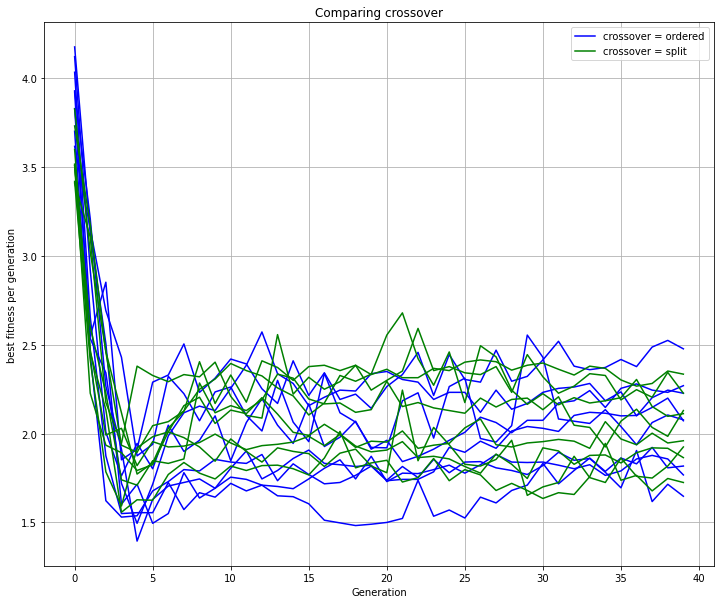

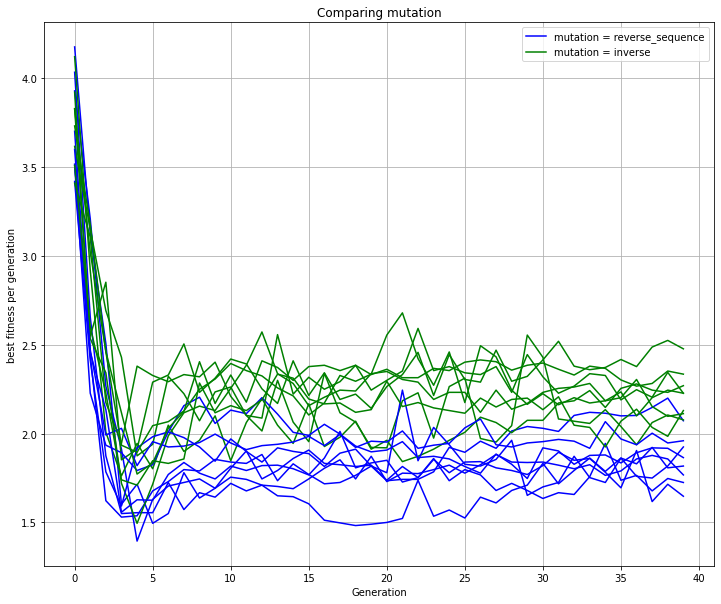

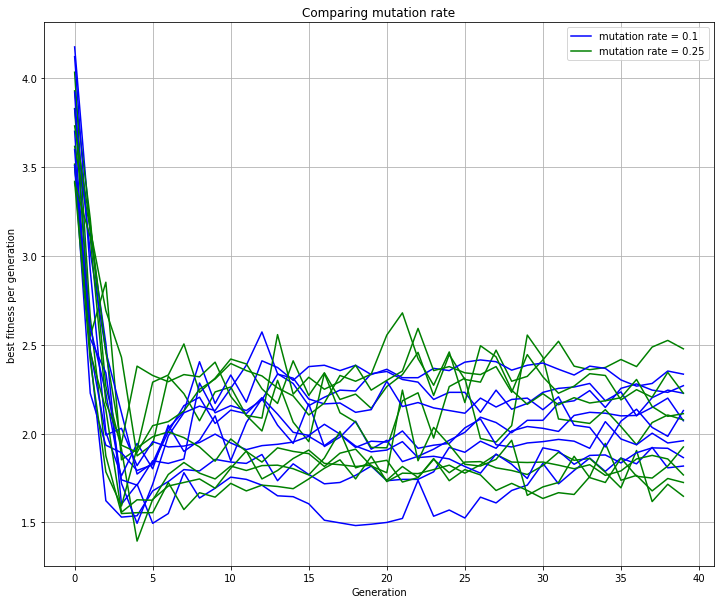

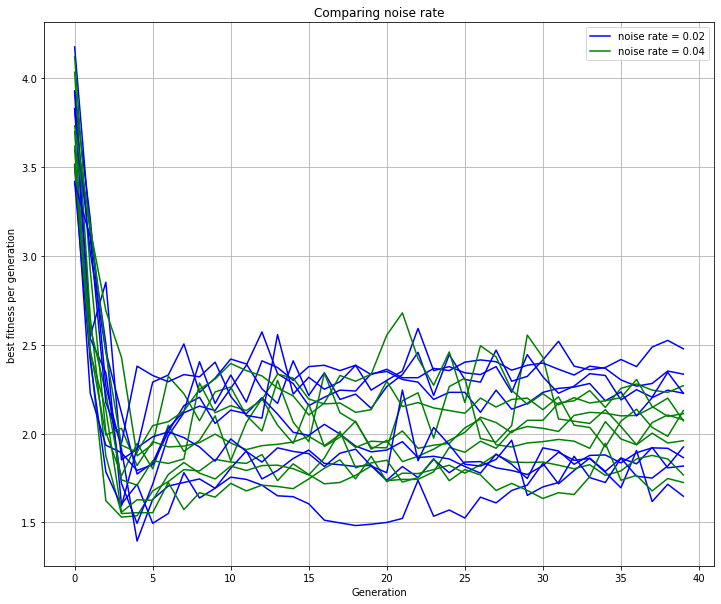

In [48]:
# Plotting best population fitness over generations

plot(results3, 'crossover', 'best fitness per generation')
plot(results3, 'mutation', 'best fitness per generation')
plot(results3, 'mutation rate', 'best fitness per generation')
plot(results3, 'noise rate', 'best fitness per generation')

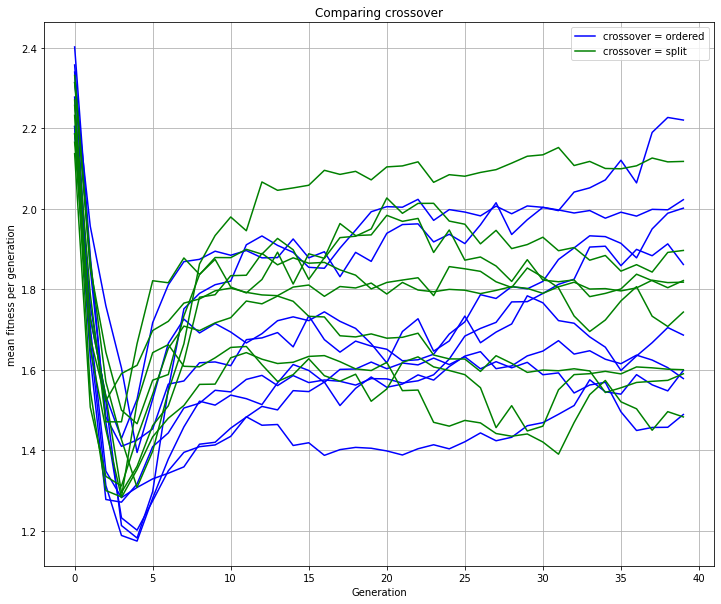

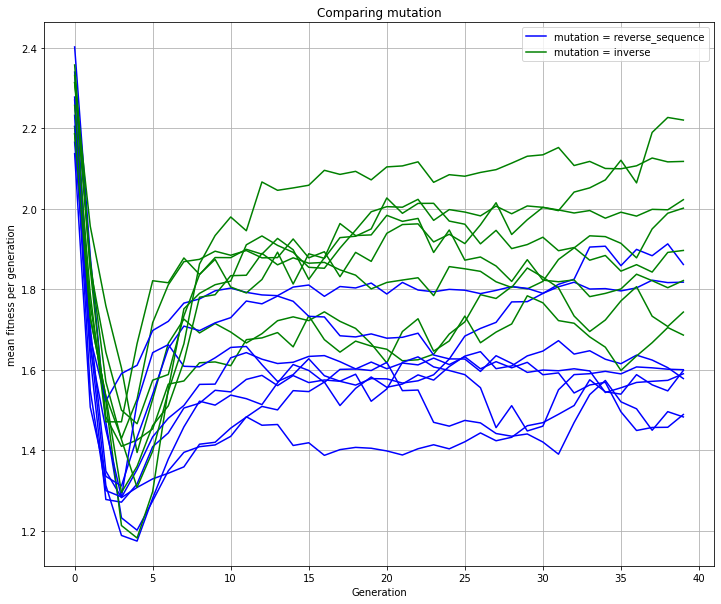

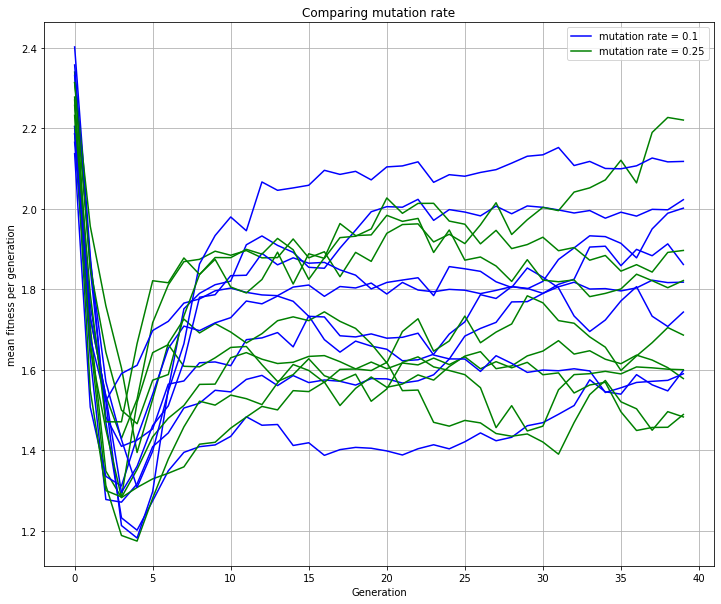

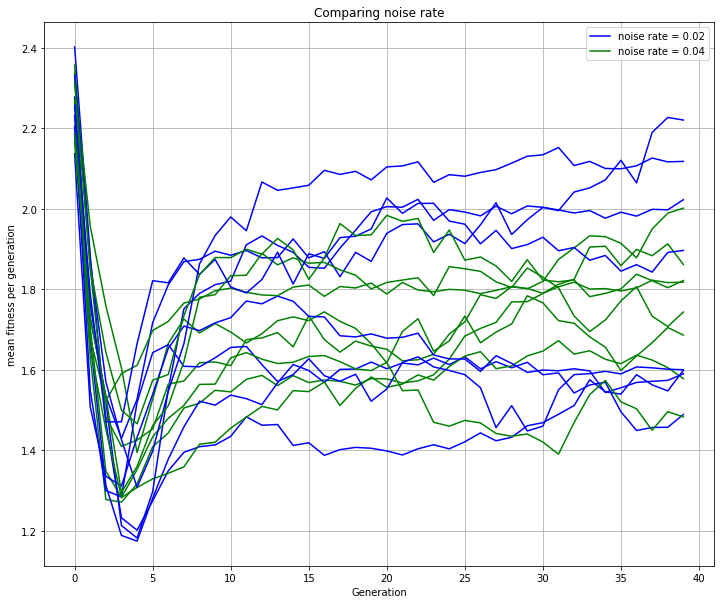

In [49]:
# Plotting mean population fitness over generations

plot(results3, 'crossover', 'mean fitness per generation')
plot(results3, 'mutation', 'mean fitness per generation')
plot(results3, 'mutation rate', 'mean fitness per generation')
plot(results3, 'noise rate', 'mean fitness per generation')

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]


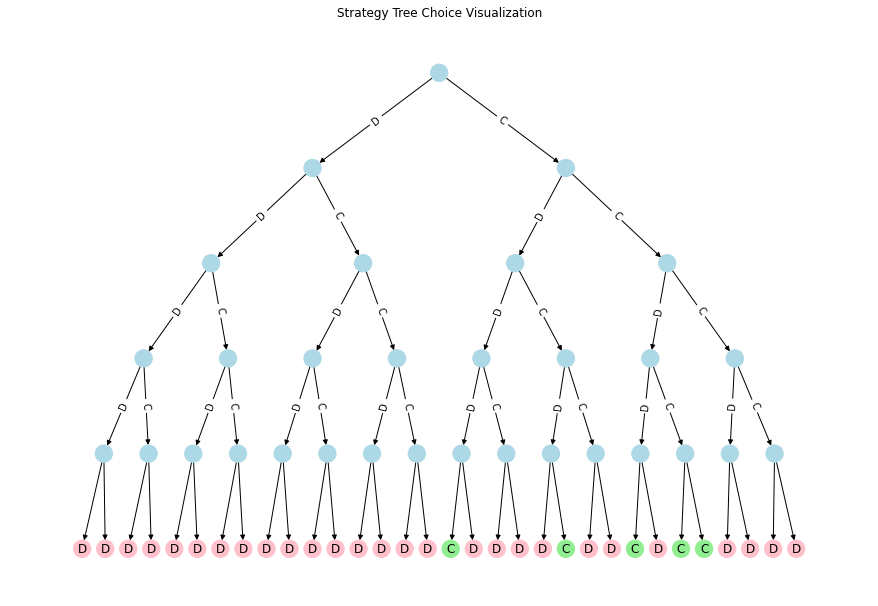

[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]


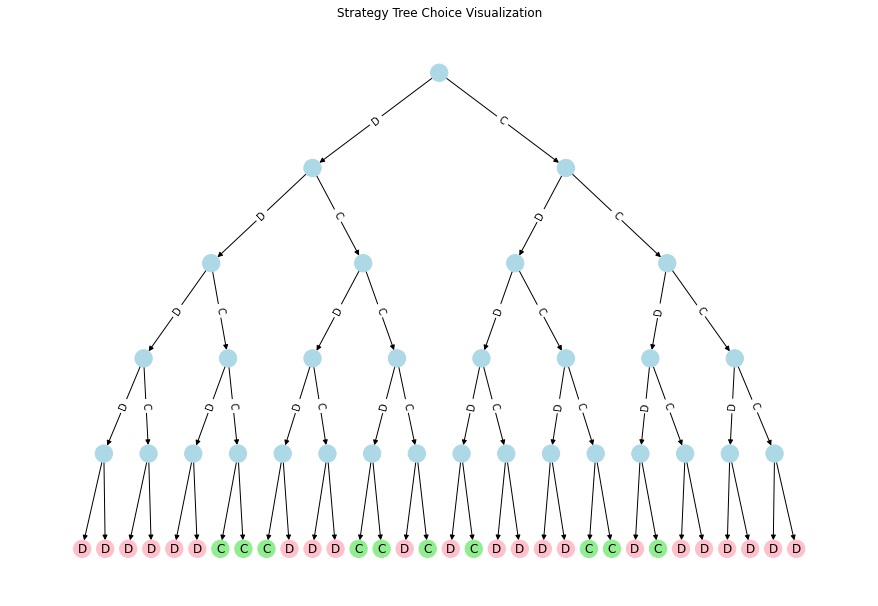

[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


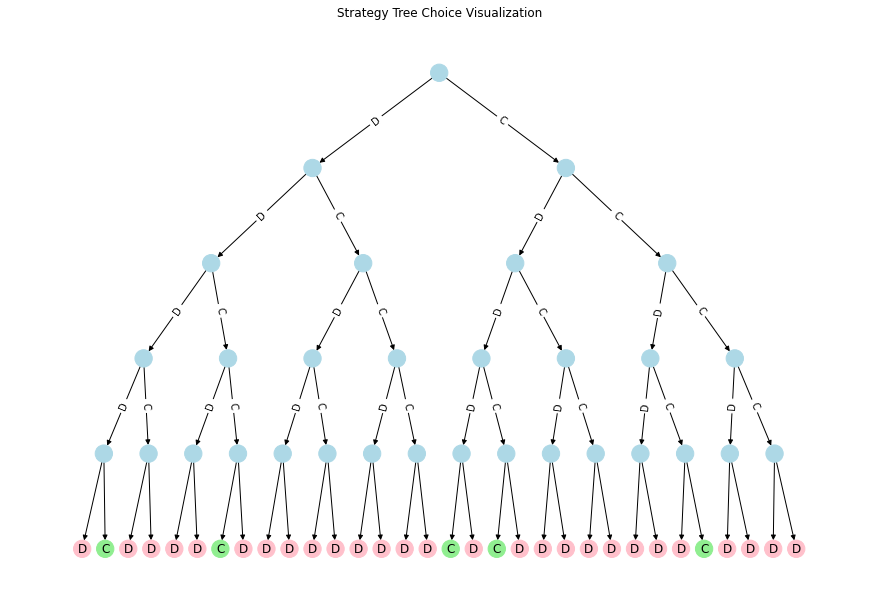

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


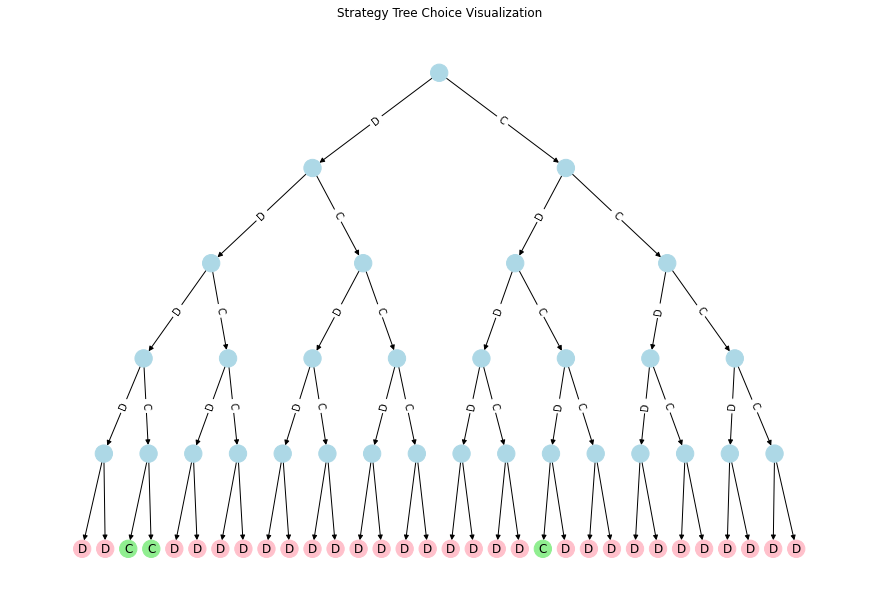

[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


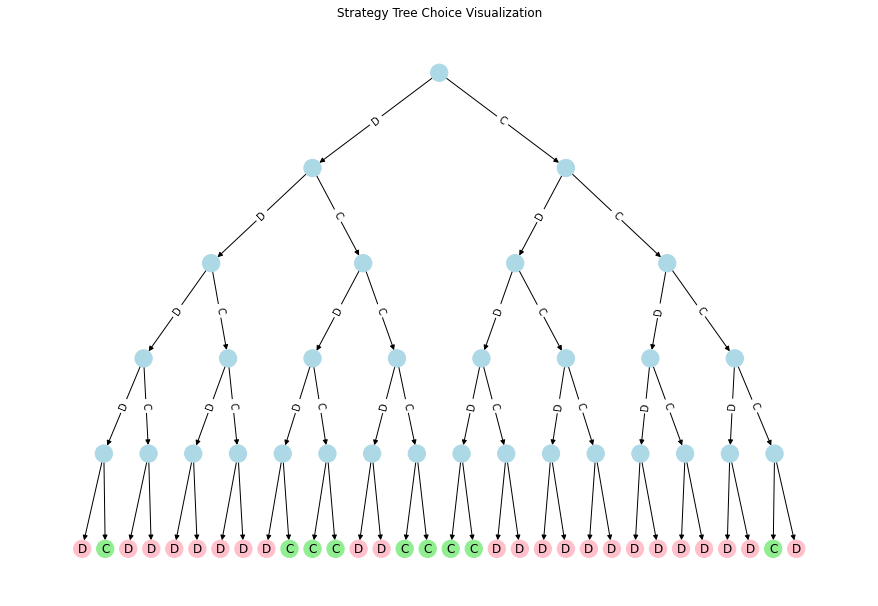

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]


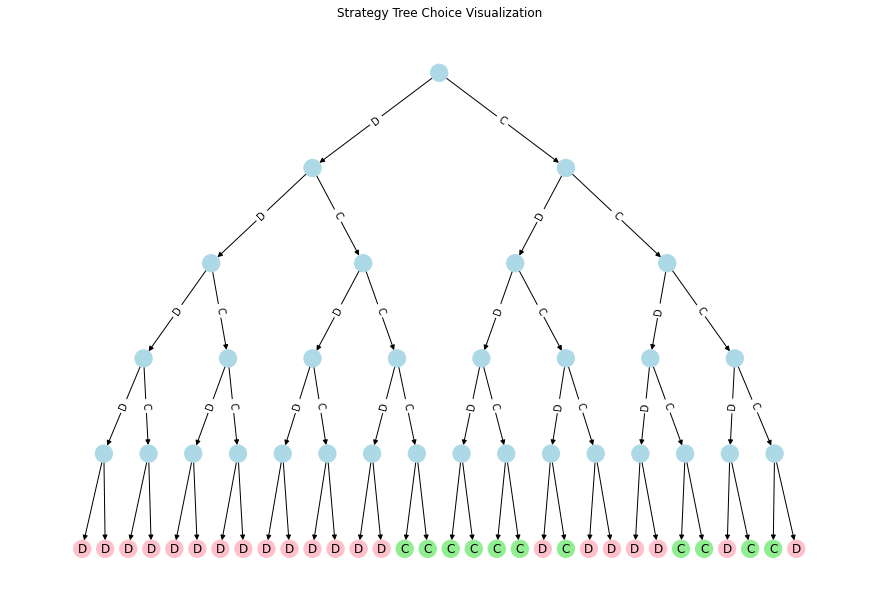

[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]


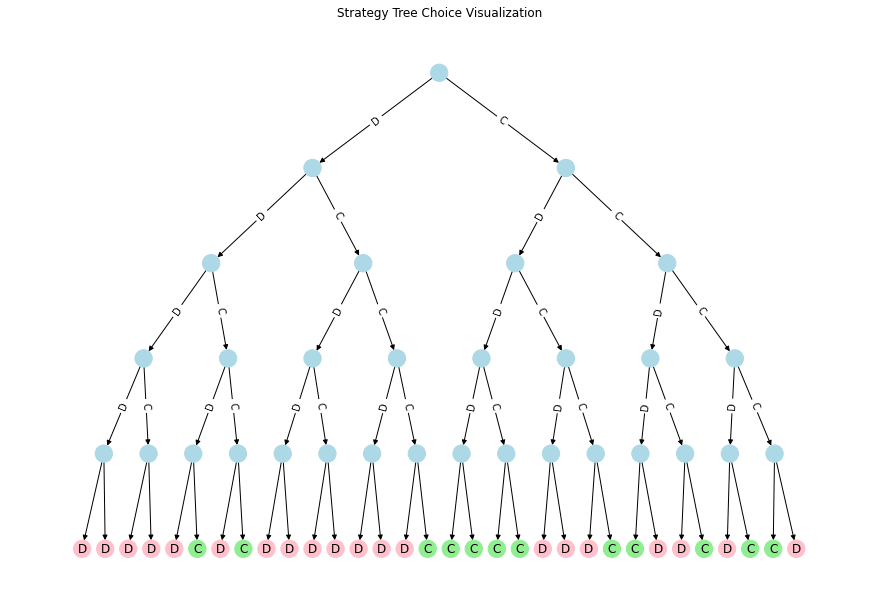

[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


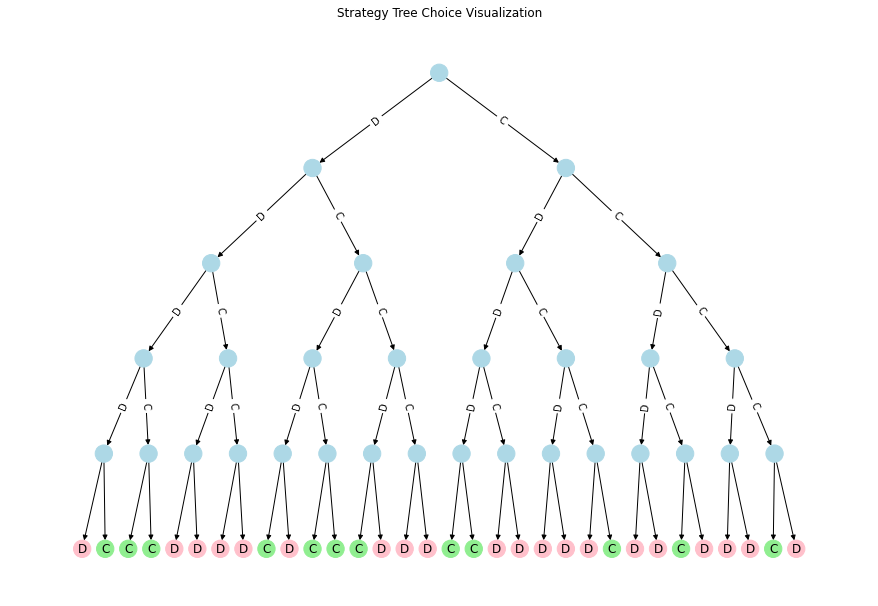

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]


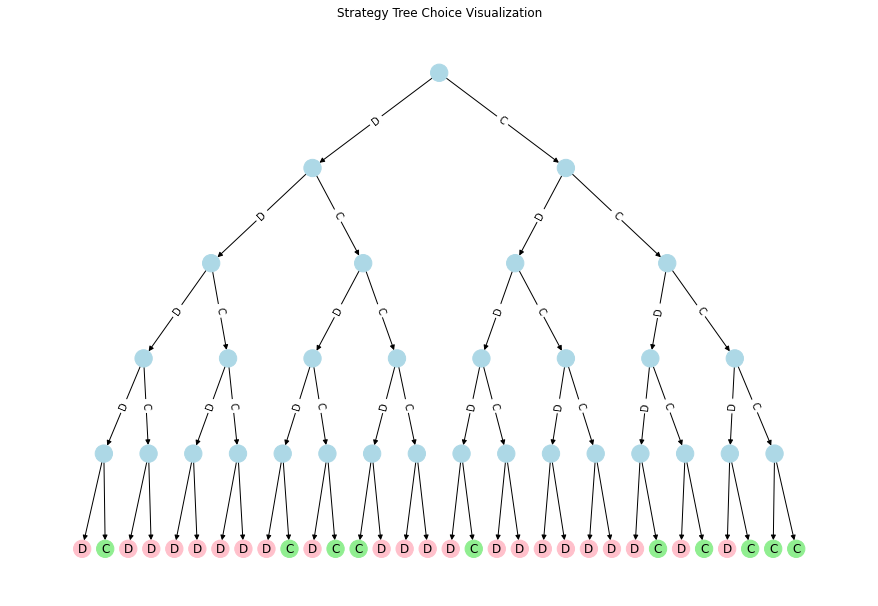

[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


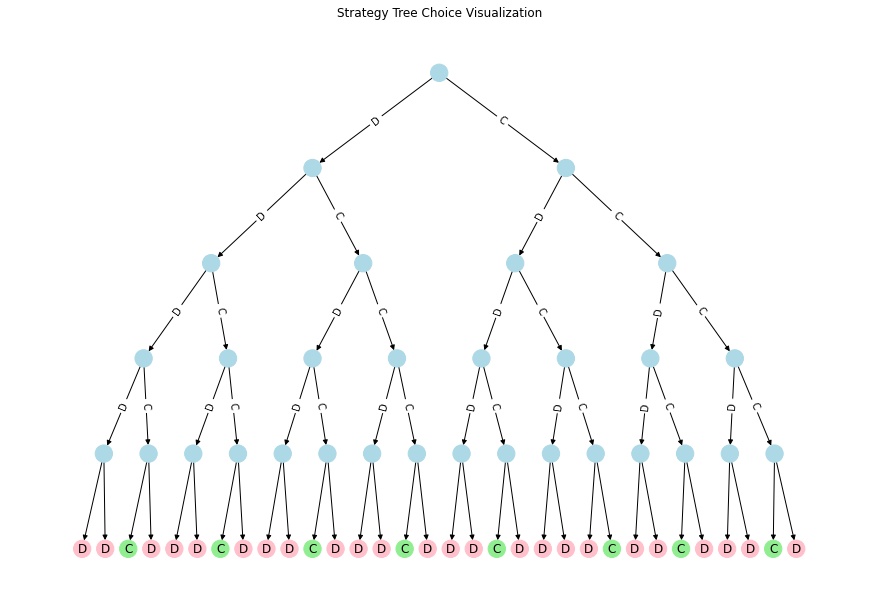

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


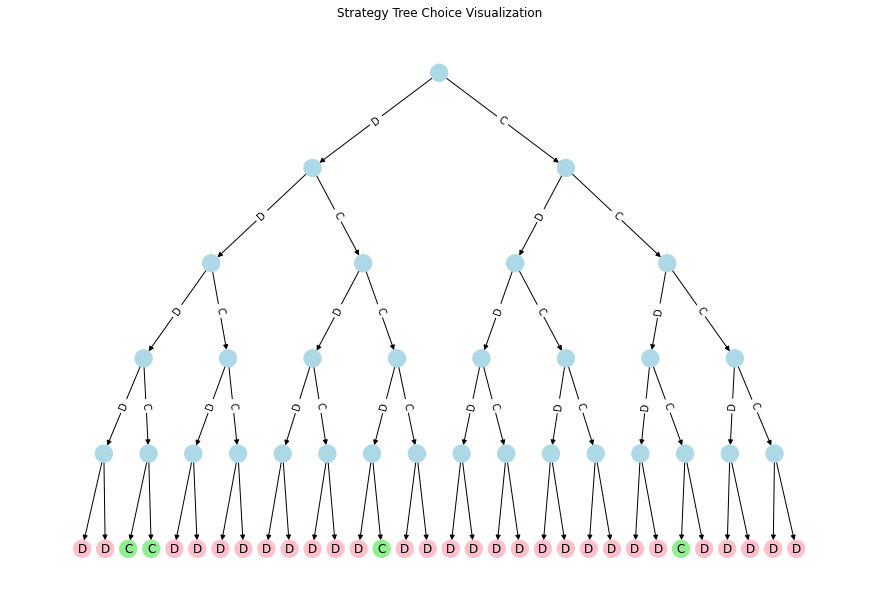

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


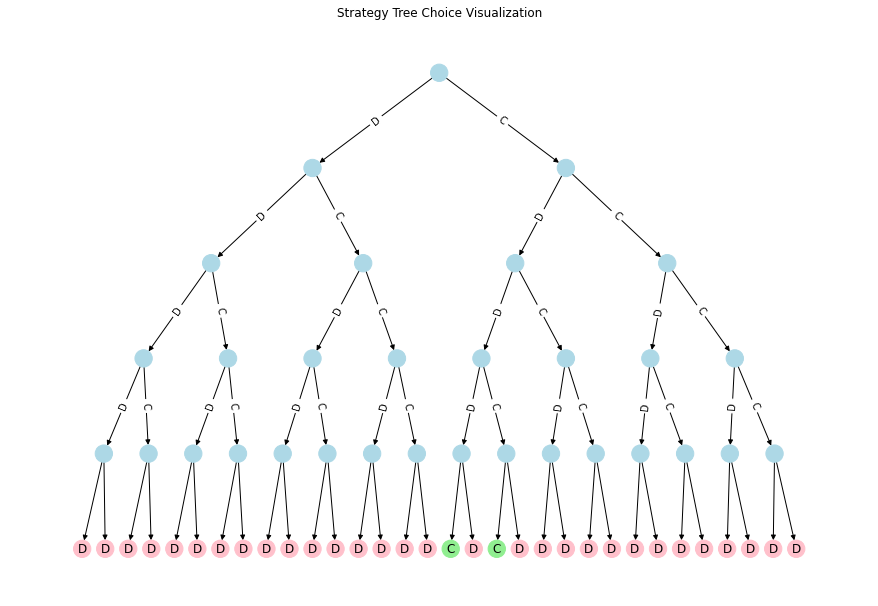

[1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


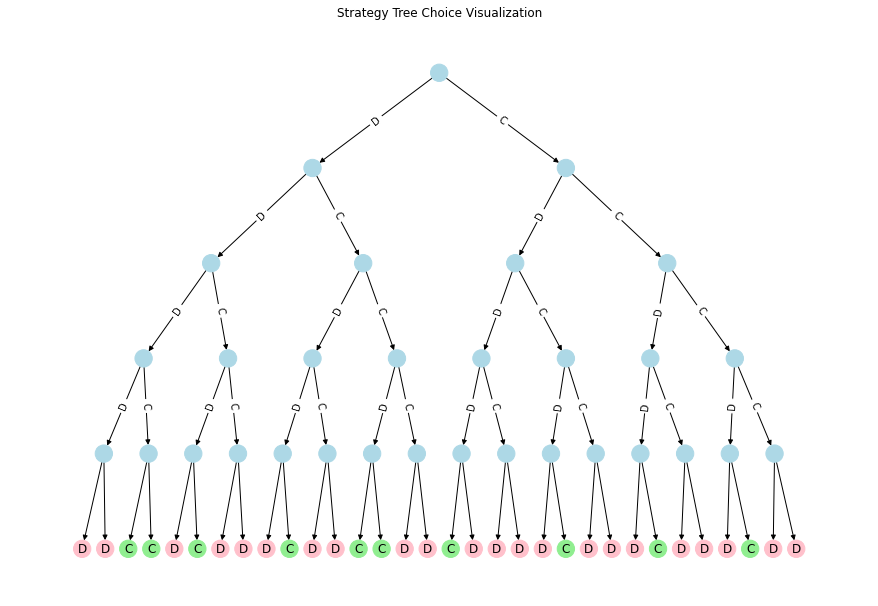

[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


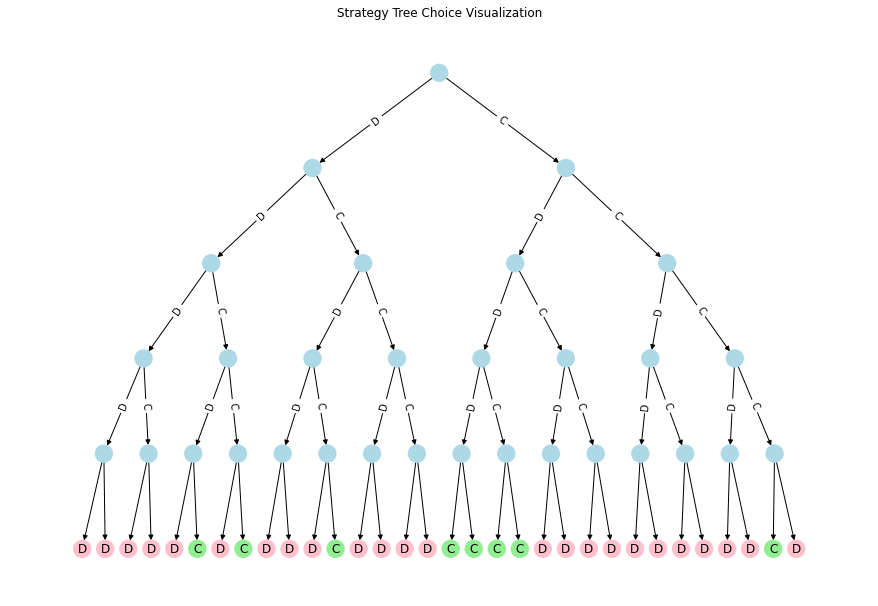

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0]


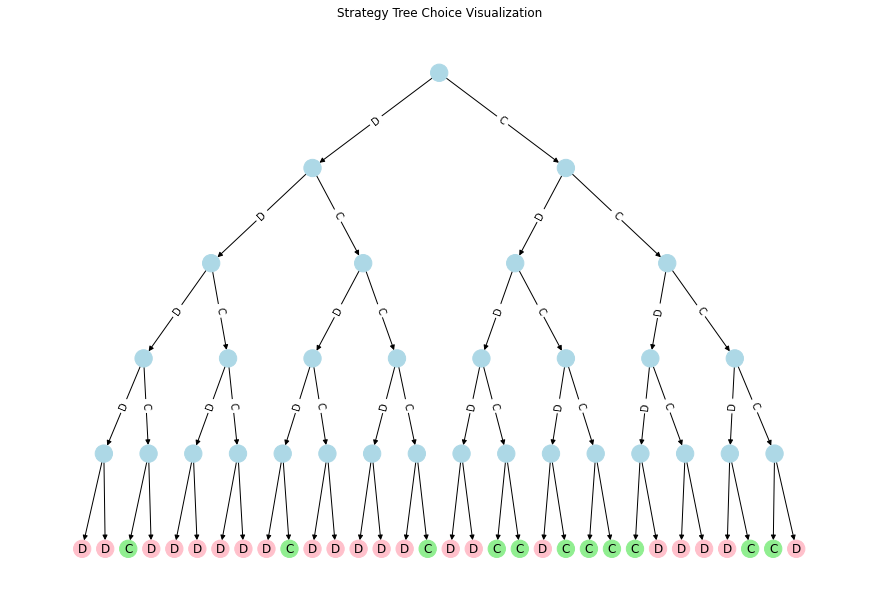

[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]


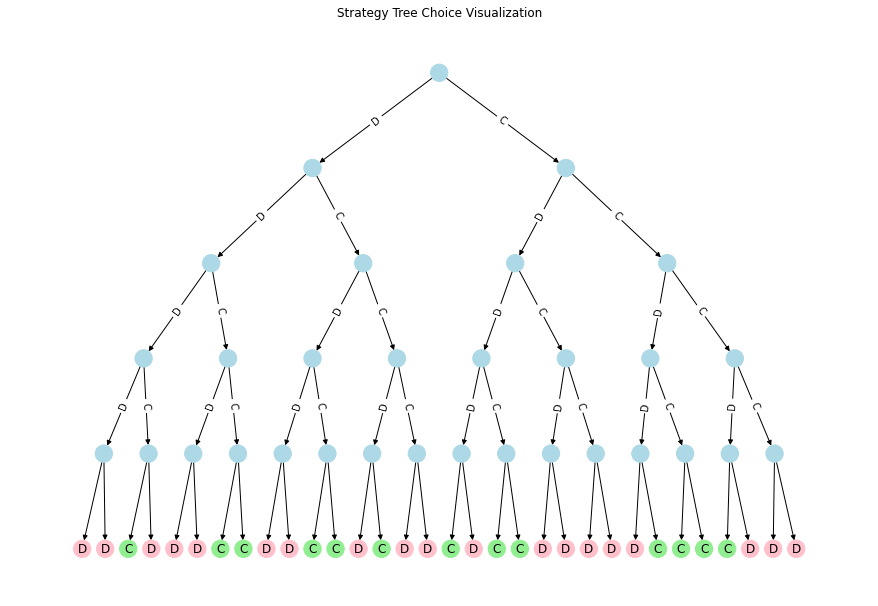

In [50]:
for best_result in results3:
    best_strategy = best_result['strategy']
    print(best_strategy)
    binary_tree_plot(best_strategy)